## Pytorch Tutorial

In [1]:
# data 작업
## DataLoader
### 데이터 셋을 순회 가능한 객체로 감쌈
## Dataset
### Sample 과 label 저장

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.FashionMNIST(
    root="data", # 학습, 테스트 데이터가 저장되는 경로
    train=True, # 학습용, 테스트 용 데이터셋 여부
    download=True, # root에 데이터가 없는 경우 인터넷에서 다운로드
    transform=ToTensor() # 특징과 정답 변형을 지정
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



c:\Users\dnsan\anaconda3\envs\torch_test\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


for X, y in test_dataloader:
    print(f'Shape of X [N,C,H,W] : {X.shape}')
    print(f'Shape of y : {y.shape} {y.dtype}')
    break

Shape of X [N,C,H,W] : torch.Size([64, 1, 28, 28])
Shape of y : torch.Size([64]) torch.int64


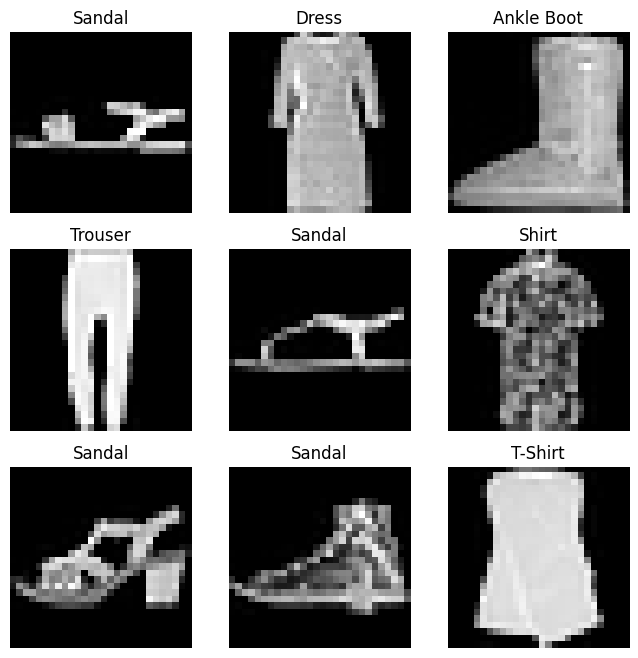

In [4]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))

cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
## 사용자 정의 Dataset 클래스
### 반드시 3개 함수 구현
### __init__, __len__, __getitem__

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        # 객체가 생성될 때 한번만 실행됨
        # 이미지 파일과, label 초기화
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # 데이터 셋 샘플 개수를 반환
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        # 주어진 인덱스 idx에 해당하는 샘플을 데이터 셋에서 불러오고 반환
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [6]:
## Dataset
### 데이터셋의 특징을 가져오고, 하나의 샘플에 정답을 지정하는 일을 한번에 함
### 모델을 학습할 때, 일반적으로 샘플들을 미니배치로 전달, 매 epoch마다 데이터를 섞어서 과적합을 막음
### python의 multiprocessing 사용하여 데이터 검색 속도를 높이려고 함

## DataLoader
### 간단한 api로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


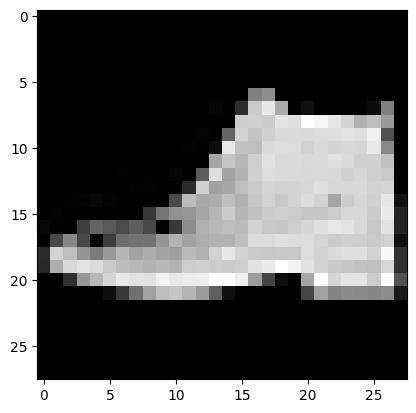

Label: 9


In [7]:
## DataLoader에 데이터셋을 불러온 뒤 필요에 따라 데이터셋 순회 가능
### 하나의 배치(64) 즉 묶음을 반환함

# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [8]:
## Model 생성

### pytorch 신경망 모델, nn.Module을 상속받는 클래스를 생성하여 정의
### __init__ 함수에서 신경망의 계층들을 정의, foward 함수에서 신경망 데이터를 어떻게 전달할지 지정
### 가능할 경우 GPU 또는 MPS로 신경망을 이동시켜 가속

# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [9]:
class newModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = newModel().to(device)
print(model)

newModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f'Predicted class: {y_pred}')

Predicted class: tensor([6], device='cuda:0')


In [11]:
input_image = torch.rand(3,28,28) # 이미지 3개로 구성된 미니배치
print(input_image.size())

torch.Size([3, 28, 28])


In [12]:
# flatten -> 이미지를 1차원으로 피는 함수

flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [13]:
# Linear -> 선형 계층 (20 units + bias)

layer1 = nn.Linear(in_features=input_image.shape[1] * input_image.shape[2], out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [14]:
# ReLU -> 음수는 모두 0, 양수만 남게하여 비선형 모델로 만듦

print(f'Before ReLU: {hidden1}\n\n')
hidden1 = nn.ReLU()(hidden1)
print(f'After ReLU: {hidden1}')

Before ReLU: tensor([[-0.3161,  0.2116,  0.1448, -0.0011, -0.8753,  0.2849, -0.0049,  0.3669,
         -0.2806,  0.2316, -0.0790,  0.5625, -0.0278, -0.3020, -0.1267, -0.2410,
          0.0051,  0.1005, -0.1310, -0.8619],
        [-0.4200,  0.3018,  0.3974, -0.2462, -0.7200,  0.4107, -0.0191,  0.5983,
         -0.3784,  0.0933,  0.1668,  0.3242,  0.1396, -0.2266,  0.0301, -0.4385,
          0.4497,  0.3023,  0.1730, -0.8072],
        [-0.2217,  0.5150,  0.1829, -0.1534, -0.7241,  0.1313, -0.0160,  0.4373,
         -0.3801,  0.3691, -0.0997,  0.4407, -0.0623, -0.0981,  0.0953, -0.4198,
          0.2766, -0.0059,  0.0146, -0.4799]], grad_fn=<AddmmBackward>)


After ReLU: tensor([[0.0000, 0.2116, 0.1448, 0.0000, 0.0000, 0.2849, 0.0000, 0.3669, 0.0000,
         0.2316, 0.0000, 0.5625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0051, 0.1005,
         0.0000, 0.0000],
        [0.0000, 0.3018, 0.3974, 0.0000, 0.0000, 0.4107, 0.0000, 0.5983, 0.0000,
         0.0933, 0.1668, 0.3242, 0.1396, 0.0000, 0.030

In [15]:
# 순서를 갖는 모듈의 컨테이너
## 데이터는 정의된 것과 같은 순서로 모든 모듈들을 통해 전달

seq_moduels = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)

input_image = torch.rand(3,28,28)
logits = seq_moduels(input_image)

In [16]:
# dim의 값을 softmax를 통해 모든 합이 1이 되는 확률로 변환

softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [17]:
## nn.Module을 상속하면 모델 객체 내부의 모든 필드들이 자동으로 추적
## paramters(), named_parameters 메소드로 모든 매개변수에 접근 가능

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f'Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n')

Model structure: newModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values: tensor([[ 0.0208,  0.0010, -0.0220,  ...,  0.0051,  0.0178, -0.0125],
        [ 0.0033, -0.0092, -0.0140,  ...,  0.0349,  0.0042, -0.0337]],
       device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values: tensor([0.0059, 0.0089], device='cuda:0', grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values: tensor([[ 0.0324, -0.0241, -0.0438,  ...,  0.0309,  0.0146, -0.0265],
        [-0.0382,  0.0405,  0.0171,  ..., -0.0180, -0.0430,  0.0019]],
       device='cuda:0', grad_fn=<SliceBackward>

In [18]:
## 모델 학습

## 손실함수와 옵티마이저 필요

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1) * len(X)
            print(f'loss: {loss:>7f} [{current:>5d} | {size:>5d}]')

In [23]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error : \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [24]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301274 [   64 | 60000]
loss: 2.295593 [ 6464 | 60000]
loss: 2.273922 [12864 | 60000]
loss: 2.266254 [19264 | 60000]
loss: 2.261909 [25664 | 60000]
loss: 2.228801 [32064 | 60000]
loss: 2.215384 [38464 | 60000]
loss: 2.201966 [44864 | 60000]
loss: 2.162243 [51264 | 60000]
loss: 2.153684 [57664 | 60000]
Test Error : 
 Accuracy: 45.0%, Avg loss: 2.146281 

Epoch 2
-------------------------------
loss: 2.146504 [   64 | 60000]
loss: 2.118406 [ 6464 | 60000]
loss: 2.081937 [12864 | 60000]
loss: 2.058002 [19264 | 60000]
loss: 2.055715 [25664 | 60000]
loss: 2.010136 [32064 | 60000]
loss: 1.970940 [38464 | 60000]
loss: 1.945672 [44864 | 60000]
loss: 1.904317 [51264 | 60000]
loss: 1.893381 [57664 | 60000]
Test Error : 
 Accuracy: 55.2%, Avg loss: 1.856168 

Epoch 3
-------------------------------
loss: 1.881043 [   64 | 60000]
loss: 1.821119 [ 6464 | 60000]
loss: 1.744872 [12864 | 60000]
loss: 1.682214 [19264 | 60000]
loss: 1.688460 [25664 | 60000]

In [25]:
## Hyperparameter
### epoch = dataset을 반복하는 횟수
### batch size = 매개변수가 갱신되기 전 신경망을 통해 전파된 데이터 샘플 수
### 학습률, 매개변수를 조절하는 비율, 값이 작을수록 학습 속도가 느려짐

learning_rate = 1e-3
batch_size = 64
epochs = 5

## 최적화 단계
### 학습 단계 : 데이터셋을 반복하고 최적의 매개변수로 수렴
### 검증/테스트 단계 : 모델 성능이 개선되고 있는지를 확인하기 위해 테스트 데이터셋을 반복함

### 1. 손실 함수
#### 학습 데이터로 나온 결과 값과 실제 값의 틀린 정도를 측정, 이 값을 최소화 하는 방향으로 학습

loss_fn = nn.CrossEntropyLoss() # LogSoftmax와 NLLLoss(Negative Log likelihood)

### 2. 옵티마이저
#### 각 학습 단계에서 모델의 오류를 줄이기 위해 모델 매개변수를 조정하는 과정
#### 최적화 알고리즘은 이 과정이 수행되는 방식을 정의

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
## 학습

### 학습 loop에서 최적화는 세단계로 이뤄짐

# 1. optimizer.zero_grad() 을 호출하여 모델 매개변수의 변화도를 재설정
## 기본적으로 변화도는 더해짐, 따라서 중복 계산을 막기 위해 반복할 때마다 0으로 설정

# 2. loss.backwards()을 호출하여 예측 손실을 역전파함

# 3. optimizer.step()
## 변화도를 계산한 뒤에는 step을 통해 역전파 단계에서 수집된 변화도를 매개변수를 조정

In [26]:
## Model Save

torch.save(model.state_dict(), 'model.pth')
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [28]:
## load Model

model = newModel().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [29]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
